In [1]:
#Import libraries
import os
import pydicom
import numpy as np
import keras
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
#Import own utilities
import preproc
import net3d_model as model_3d
import utils
import keraOverlay as overlay
import keras.callbacks as callbacks

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data and masks as dicom files
data_dir = '../../../data'                   #Please change the path accordingly before make any changes
normalNames = data_dir + '/GoodData_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

In [9]:
n_slices = 64
size = 64
#model, prediction = model_3d.conv_net(size=size, activation_type="sigmoid", n_slices=n_slices, depth=5, n_base_filters=16)
model, prediction = model_3d.simple_unet(n_slices, size)
#model.summary()
# This visualization might not work depending on how graphviz is installed, but it gives a simple overview of the structure.
#To do: output this image to file or in pop up window
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.compile(loss=overlay.dice_coef_loss, optimizer='adam', metrics=['acc', overlay.dice_coef])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', model_3d.dice_coef])


In [12]:
normal_namelist = []
with open(normalNames) as f:
    content = f.readlines()
    normal_namelist = [x.strip() for x in content] 
#Cross Validation
n_data = 5
k = 5   #Number of folds
n_batch = 1 #Number of batches
data_name_list = normal_namelist[:n_data]

In [14]:

folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(np.array(data_name_list), np.zeros(n_data)))

#callbacks
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=0.003, verbose=0, mode='auto')

box_size=64
complete=False
toBoxes=True
only_valid=True

for index in range(k):
    print(index+1, "/", k, "fold")
    train_list = [data_name_list[i] for i in folds[index][0]]
    val_list = [data_name_list[i] for i in folds[index][1]]
    
#test the number of boxes!   
    train_box_no = []
    val_box_no = []
    
    for filename in train_list:
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=only_valid)
        train_box_no.append(number)
    n_boxes_train = np.sum(np.array(train_box_no))
    print("box number in train set:",n_boxes_train, train_box_no)
    
    
    for filename in val_list:
        try:
            sample = pydicom.read_file(os.path.join(img_dir, filename))
            mask = pydicom.read_file(os.path.join(msk_dir, filename.split('.')[0] + '.result.dcm'))
        except:
            print("Error: unable to load data!")
        number, _, _ = preproc.to3dpatches(sample.pixel_array, mask.pixel_array, depth=box_size, size=box_size, complete=complete, toBoxes=True, onlyValid=only_valid)
        val_box_no.append(number)
    n_boxes_val = np.sum(np.array(val_box_no))
    print("box number in val set:", n_boxes_val, val_box_no)
    
    
    #print(train_list, val_list)
    
    history = model.fit_generator(overlay.generate_box_data(img_dir, msk_dir, train_list, batch_size=n_batch, only_valid=True), 
                                  epochs=1, verbose=1, steps_per_epoch=int(np.ceil(n_boxes_train/n_batch)),
                                  validation_data=overlay.generate_box_data(img_dir, msk_dir, val_list, batch_size=1),
                                  validation_steps=n_boxes_val,
                                  callbacks=[earlystop])


1 / 5 fold
box number in train set 10 [1, 3, 3, 3]
box number in val set 5 [5]
Epoch 1/1
10/10 [==============================] - 29s 3s/step - loss: 0.8378 - acc: 0.9473 - dice_coef: 0.1622 - val_loss: 1.0000 - val_acc: 0.9888 - val_dice_coef: 1.2487e-05
2 / 5 fold
box number in train set 12 [1, 5, 3, 3]
box number in val set 3 [3]
Epoch 1/1
12/12 [==============================] - 37s 3s/step - loss: 0.8437 - acc: 0.9374 - dice_coef: 0.1563 - val_loss: 1.0000 - val_acc: 0.9673 - val_dice_coef: 1.4902e-05
3 / 5 fold
box number in train set 12 [1, 3, 5, 3]
box number in val set 3 [3]
Epoch 1/1
12/12 [==============================] - 36s 3s/step - loss: 0.8360 - acc: 0.9473 - dice_coef: 0.1640 - val_loss: 1.0000 - val_acc: 0.9807 - val_dice_coef: 1.6514e-05
4 / 5 fold
box number in train set 14 [3, 5, 3, 3]
box number in val set 1 [1]
Epoch 1/1
14/14 [==============================] - 51s 4s/step - loss: 0.8371 - acc: 0.9523 - dice_coef: 0.1629 - val_loss: 1.0000 - val_acc: 0.9887 - va

In [32]:
#Load data

x_list, y_list = utils.load_data(img_dir, msk_dir, normal_namelist, sigma_image=0, sigma_mask=0, scaling=4, OPaslist=True)

In [36]:
n_slice = 64
size = 64
print(len(x_list))
index = 9

#data = utils.padImage(x_list[index])
#data_tobox = preproc.to3dpatches(data, )
predictions = model.predict(x_list[index].reshape(1,n_slice,size,size,1), steps=1)

15


In [37]:
from keras import backend

print(backend.floatx())

#dice = model_3d.dice_coef(predictions[0],x_list[index])
result = predictions[0]
result[result>=0.7] = 1
result[result<0.7] = 0
dice = overlay.dice_coef(y_list[index].reshape(1,64,64,64),result.reshape(1,64,64,64))
#dice = model_3d.dice_coef(backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64),backend.cast_to_floatx(y_list[0]).reshape(1,64,64,64))

#print(predictions[0][slice_index].dtype)
#dice = dice_coef(y_list[index],predictions[0])
print(dice)
#dice = backend.print_tensor(dice*8, message='y_pred = ')
#backend.print_tensor(dice, message='')
#print(dice)
#piece = predictions[0]
#piece = piece[piece > 0.9]
#dice = model_3d.dice_coef(piece,piece)
backend.eval(dice)

float32
Tensor("Mean_9:0", shape=(), dtype=float32)


0.5682927

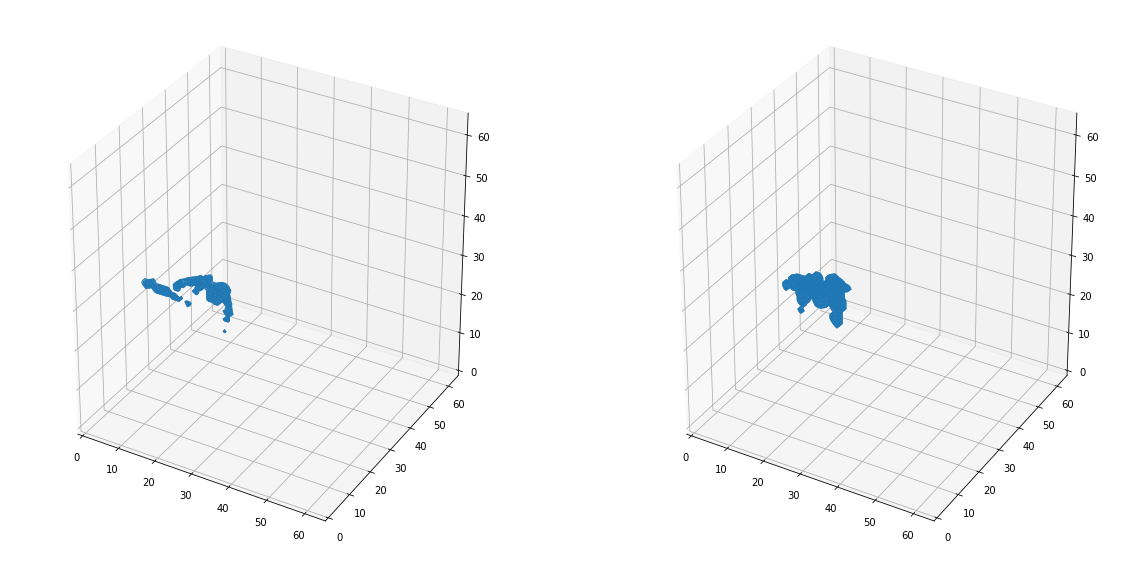

In [38]:
utils.plot_3d(predictions[0].reshape(64,64,64), y_list[index], threshold=0.5, threshold2=0.0)